# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Notes
* AKA not necessary - drop
* License number has more unique values than DBA - may be because of franchises. Drop DBA and keep License Number for identification. Keep Nans for License number b/c xgboost can handle it
* Drop City - no real variance
* Drop State - no variance
* Target encode Zip
* Inspection Date to datetime
* Target encode Inspection Type
* Drop Long and Lat

### Build Encoding Function

In [84]:
import numpy as np
# create target encoder function
def target_encoder(df,col,target,alpha=100):
    gb_obj = df.groupby(col)[target].agg(['mean', 'count'])
    target_mean = df[target].mean()
    alpha=alpha
    gb_obj['encoder'] = ((gb_obj['mean']*gb_obj['count'])+(target_mean*alpha))/(gb_obj['count']+alpha)
    
    target_encoder = gb_obj['encoder'].to_dict()
   # target_encoder['nan'] = np.NaN
    target_encoder[999.0] = np.NaN
    return target_encoder

# Do not mess with encoding dictionaries

In [100]:
# create target encoder dictionary (not worried about overfit with
# train data, so use all points)
new = train.copy()
new['Violations'] = new['Violations'].str.extract('(\d\d)', expand=True)
        
zip_enc = target_encoder(new, 'Zip', 'Fail')
inspection_enc = target_encoder(new, 'Inspection Type', 'Fail')
violations_enc = target_encoder(new, 'Violations', 'Fail')
facility_enc = target_encoder(new, 'Facility Type', 'Fail')

### wrangling function

In [146]:
def wrangle(x):
        X = x.copy()
        # Drop
        X = X.drop(['Inspection ID', 'DBA Name', 'AKA Name', 
                    'Address','City', 'State', 'Latitude', 
                    'Longitude', 'Location'], axis=1)
        
        # Handle Dates
        X['Inspection Date'] = pd.to_datetime(X['Inspection Date'])

        X['DayOfWeek of Inspection'] = X['Inspection Date'].dt.dayofweek
        X['Day of Inspection'] = X['Inspection Date'].dt.day
        X['Month of Inspection'] = X['Inspection Date'].dt.month
        X['Year of Inspection'] = X['Inspection Date'].dt.year
        
        # Drop Date b/c xgboost doesn't like it
        X = X.drop('Inspection Date', axis=1)
        
        # Handle Violations to string
        X['Violations'] = X['Violations'].str.extract('(\d\d)', expand=True)
        
        # Clean unknown zips
        def clean_zips(zip_x):
            if zip_x not in train['Zip'].to_list():
                zip_x = 999
        X['Zip'] = X['Zip'].fillna(999).apply(lambda x: clean_zips(x))    

        # Clean unknown inspection types
        def clean_inspection(insp_x):
            if insp_x not in train['Inspection Type'].to_list():
                insp_x = 999
        X['Inspection Type'] = X['Inspection Type'].fillna(999).apply(lambda x: clean_inspection(x)) 
        
        # Clean unknown violation types
        def clean_violations(viol_x):
            if viol_x not in train['Violations'].to_list():
                viol_x = 999
        X['Violations'] = X['Violations'].fillna(999).apply(lambda x: clean_violations(x)) 
        
        # Clean unknown facility types
        def clean_facility(faci_x):
            if faci_x not in train['Violations'].to_list():
                faci_x = 999
        X['Facility Type'] = X['Facility Type'].fillna(999).apply(lambda x: clean_facility(x))
        
        # Target encode 
        X['Zip'] = X['Zip'].fillna(999).apply(lambda x: zip_enc[x])
        X['Inspection Type'] = X['Inspection Type'].fillna(999).apply(lambda x: inspection_enc[x])
        X['Violations'] = X['Violations'].fillna(999).apply(lambda x: violations_enc[x])
        X['Facility Type'] = X['Facility Type'].fillna(999).apply(lambda x: facility_enc[x])
        
        # Fix Risk
        risk_dic = {'Risk 1 (High)':1, 'Risk 2 (Medium)': 2,
                   'Risk 3 (Low)': 3}
        X['Risk'] = X['Risk'].map(risk_dic)
        return X



In [141]:
a = wrangle(train)

In [119]:
a.dtypes

License #                  float64
Facility Type              float64
Risk                       float64
Zip                        float64
Inspection Type            float64
Violations                 float64
Fail                         int64
DayOfWeek of Inspection      int64
Day of Inspection            int64
Month of Inspection          int64
Year of Inspection           int64
dtype: object

# Begin Modeling
### Initial training

In [120]:
train_wrangled = wrangle(train)
X_train = train_wrangled.drop('Fail', axis=1)
y_train = train_wrangled['Fail']

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)


In [136]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

model = XGBClassifier()
#cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)

model.fit(X_train, y_train)

preds = model.predict_proba(X_val)[:,1]
print ('ROC AUC Score',roc_auc_score(y_val,preds))

ROC AUC Score 0.9883853798964317


In [135]:
# go ahead and fit on all of the data
train_wrangled = wrangle(train)
X_train = train_wrangled.drop('Fail', axis=1)
y_train = train_wrangled['Fail']

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [147]:
test_wrangled = wrangle(test)
X_test = train_wrangled.drop('Fail', axis=1)
y_test = train_wrangled['Fail']

preds = model.predict_proba(X_test)[:,1]
print ('ROC AUC Score',roc_auc_score(y_test,preds))

ROC AUC Score 0.9877590012855704


# I think that's good
### Unless I'm misinterpretting something, which would be embarassing
### I checked to see if I'm leaking data and it looks like no

In [173]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

In [164]:
I = list(model.feature_importances_)
J = X_train.columns.to_list()

for i,j in zip(I,J):
    print(j,' ', i)

License #   0.07747489
Facility Type   0.090387374
Risk   0.012912482
Zip   0.05738881
Inspection Type   0.22094691
Violations   0.31707317
DayOfWeek of Inspection   0.008608322
Day of Inspection   0.018651363
Month of Inspection   0.024390243
Year of Inspection   0.17216642


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 <a list of 8 Text xticklabel objects>)

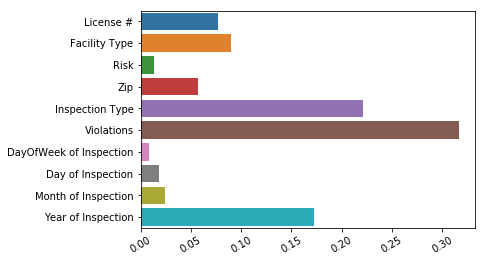

In [180]:
sns.barplot(x=I, y=J)
plt.xticks(rotation=30)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._